In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

data_path = '/Users/vikash/Downloads/DS TakeHome Assignment/data/'

### Preparation of Train Data 
***

In [2]:
%%time
train_pings = pd.read_parquet('df_pings_local.parquet', engine='fastparquet')

CPU times: user 1.8 s, sys: 86.8 ms, total: 1.88 s
Wall time: 2.33 s


In [3]:
train_pings.head()
train_pings.shape

,driver_id,date_local,Ping_Min,Ping_Max
0,111556,2017-06-01,2017-06-01 08:09:00,2017-06-01 10:22:00
1,111556,2017-06-02,2017-06-02 08:22:00,2017-06-02 10:52:00
2,111556,2017-06-05,2017-06-05 08:37:00,2017-06-05 13:17:00
3,111556,2017-06-06,2017-06-06 08:51:00,2017-06-06 11:58:00
4,111556,2017-06-07,2017-06-07 08:22:15,2017-06-07 11:00:00


(42331, 4)

In [4]:
%%time
from datetime import datetime
datetimeFormat = '%Y-%m-%d %H:%M:%S'

train_pings['Ping_Min']= train_pings['Ping_Min'].apply(lambda x: datetime.strptime(x, datetimeFormat))
train_pings['Ping_Max']= train_pings['Ping_Max'].apply(lambda x: datetime.strptime(x, datetimeFormat))
train_pings['diff'] = train_pings['Ping_Max'] - train_pings['Ping_Min']
train_pings['online_hours'] = train_pings['diff'].apply(lambda x: round(x.seconds / 3600.0, 0))

CPU times: user 2.76 s, sys: 27.4 ms, total: 2.79 s
Wall time: 2.81 s


In [5]:
cols = ['driver_id', 'date_local', 'online_hours']
pings = train_pings.loc[:,cols]

In [6]:
pings.head()
pings.shape

,driver_id,date_local,online_hours
0,111556,2017-06-01,2.0
1,111556,2017-06-02,2.0
2,111556,2017-06-05,5.0
3,111556,2017-06-06,3.0
4,111556,2017-06-07,3.0


(42331, 3)

### Adding additional dates which are missing for each driver with zero hours
***

In [7]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

s=[]
start_dt = date(2017, 6, 1)
end_dt = date(2017, 6, 21)
for dt in daterange(start_dt, end_dt):
    s.append(dt.strftime("%Y-%m-%d"))

In [8]:
series = pd.DataFrame(s, columns = ['date'])
series.dtypes
series.shape
drivers = pd.DataFrame(train_pings.driver_id.unique(), columns = ['driver_id'])
drivers.shape

date    object
dtype: object

(21, 1)

(2480, 1)

In [9]:
## Taking Cross tab
drivers['index'] = 1
series['index'] = 1
new_df = pd.merge(drivers, series, on ='index', how = 'inner')
new_df.drop(columns='index', axis= 1, inplace = True)

final_pings = pd.merge(new_df, pings, left_on = ['driver_id', 'date'], right_on = ['driver_id', 'date_local'], how ='left')
final_pings.drop(columns='date_local', axis= 1, inplace = True)
final_pings['online_hours'].fillna(0, inplace=True)
final_pings.head()

,driver_id,date,online_hours
0,111556,2017-06-01,2.0
1,111556,2017-06-02,2.0
2,111556,2017-06-03,0.0
3,111556,2017-06-04,0.0
4,111556,2017-06-05,5.0


### Fetching the details of drivers
***

In [10]:
drivers = pd.read_csv(data_path + 'drivers.csv')
len(drivers.driver_id.unique())
drivers.shape

2497

(2500, 4)

#### Looking into the Duplicate Records

In [11]:
drivers.sort_values(by = ['driver_id', 'age'], inplace = True)
drivers[drivers.duplicated(['driver_id'], keep=False)]

,driver_id,gender,age,number_of_kids
231,320227,MALE,22,4
388,320227,MALE,42,4
1765,799250,FEMALE,23,0
1311,799250,FEMALE,27,4
1550,800600,FEMALE,22,0
2008,800600,FEMALE,28,1


#### Considering the Latest records

In [12]:
drivers = drivers.drop_duplicates(subset= 'driver_id', keep = 'last')
drivers[drivers.duplicated(['driver_id'], keep=False)]

,driver_id,gender,age,number_of_kids


**Comment** : *No more duplicate records present in the driver's data*

In [13]:
train_data = pd.merge(final_pings, drivers, on = 'driver_id', how = 'inner')
train_data.shape
train_data.head()

(52080, 6)

,driver_id,date,online_hours,gender,age,number_of_kids
0,111556,2017-06-01,2.0,FEMALE,49,4
1,111556,2017-06-02,2.0,FEMALE,49,4
2,111556,2017-06-03,0.0,FEMALE,49,4
3,111556,2017-06-04,0.0,FEMALE,49,4
4,111556,2017-06-05,5.0,FEMALE,49,4


## Feature Engineering
***

### 1. Weekday of the Week

In [14]:
import datetime
train_data['date'] = train_data['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
train_data['weekday'] = train_data['date'].apply(lambda x: x.weekday())
train_data.dtypes

driver_id                  int64
date              datetime64[ns]
online_hours             float64
gender                    object
age                        int64
number_of_kids             int64
weekday                    int64
dtype: object

### 2. Weekend Flag

In [15]:
train_data['weekend_flag'] = 0
train_data.loc[train_data['weekday'].isin([5,6]), 'weekend_flag']=1

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

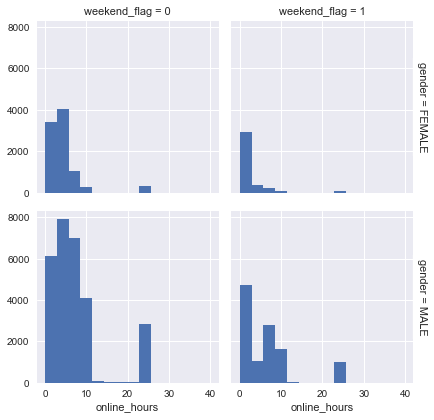

In [22]:
grid = sns.FacetGrid(train_data, row="gender", col="weekend_flag", margin_titles=True)
grid.map(plt.hist, "online_hours", bins=np.linspace(0, 40, 15));

/Users/vikash/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


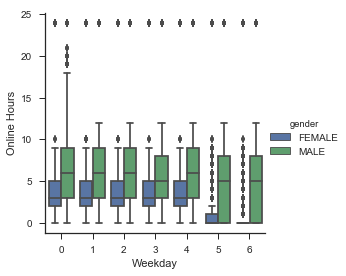

In [25]:
plt.figure(figsize=(15,8))
with sns.axes_style(style='ticks'):
    g = sns.factorplot("weekday", "online_hours", "gender", data=train_data, kind="box")
    g.set_axis_labels("Weekday", "Online Hours");

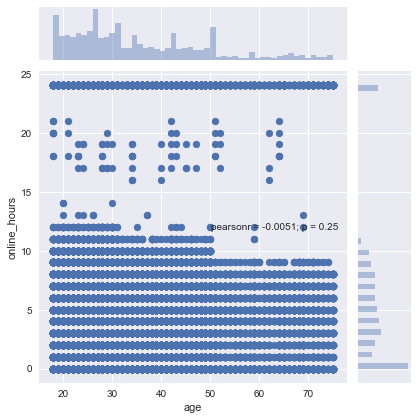

In [39]:
sns.set(style="darkgrid", rc={'figure.figsize':(20,10)})
sns.jointplot( "age","online_hours", data=train_data, kind='scatter')

### 3. Age Buckets

In [36]:
train_data['age_bucket'] = 1
train_data.loc[(train_data['age'] > 30) & (train_data['age'] <= 50), 'age_bucket'] = 2
train_data.loc[train_data['age'] > 50 , 'age_bucket'] = 3

/Users/vikash/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


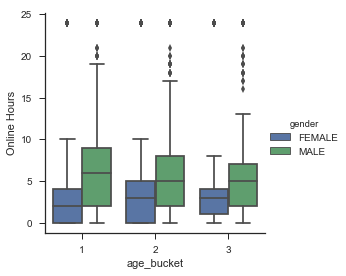

In [37]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("age_bucket", "online_hours", "gender", data=train_data, kind="box")
    g.set_axis_labels("age_bucket", "Online Hours");

In [16]:
train_data.to_parquet('train_data.parquet', engine='fastparquet', compression ='GZIP')

## Preparation of Test Data

In [22]:
test = pd.read_csv('test.csv')
test.sort_values(by = ['driver_id', 'date'], inplace = True)
test.reset_index(drop = True , inplace = True)

In [26]:
test.shape
test.head()

(17500, 3)

,driver_id,date,online_hours
0,111556,2017-6-22,2
1,111556,2017-6-23,5
2,111556,2017-6-24,0
3,111556,2017-6-25,0
4,111556,2017-6-26,0


In [27]:
drivers.head()

,driver_id,gender,age,number_of_kids
25,111556,FEMALE,49,4
1385,111575,MALE,49,0
1534,111779,MALE,26,0
465,111839,MALE,25,0
1762,112486,FEMALE,44,1


In [28]:
## Merging Test with Drivers Data 
test_data = pd.merge(test, drivers, on = 'driver_id', how = 'inner')
test_data.shape
test_data.head()

(17500, 6)

,driver_id,date,online_hours,gender,age,number_of_kids
0,111556,2017-6-22,2,FEMALE,49,4
1,111556,2017-6-23,5,FEMALE,49,4
2,111556,2017-6-24,0,FEMALE,49,4
3,111556,2017-6-25,0,FEMALE,49,4
4,111556,2017-6-26,0,FEMALE,49,4


In [29]:
## Creating weekday variable for test data
import datetime
test_data['date'] = test_data['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
test_data['weekday'] = test_data['date'].apply(lambda x: x.weekday())

## Creating Weekend Flag
test_data['weekend_flag'] = 0
test_data.loc[test_data['weekday'].isin([5,6]), 'weekend_flag']=1

## Creating Age Bucket variable for Test Data
test_data['age_bucket'] = 1
test_data.loc[(test_data['age'] > 30) & (test_data['age'] <= 50), 'age_bucket'] = 2
test_data.loc[test_data['age'] > 50 , 'age_bucket'] = 3

test_data.head()
test_data.dtypes

,driver_id,date,online_hours,gender,age,number_of_kids,weekday,weekend_flag,age_bucket
0,111556,2017-06-22,2,FEMALE,49,4,3,0,2
1,111556,2017-06-23,5,FEMALE,49,4,4,0,2
2,111556,2017-06-24,0,FEMALE,49,4,5,1,2
3,111556,2017-06-25,0,FEMALE,49,4,6,1,2
4,111556,2017-06-26,0,FEMALE,49,4,0,0,2


driver_id                  int64
date              datetime64[ns]
online_hours               int64
gender                    object
age                        int64
number_of_kids             int64
weekday                    int64
weekend_flag               int64
age_bucket                 int64
dtype: object

In [30]:
test_data.to_parquet('test_data.parquet', engine='fastparquet', compression ='GZIP')

## Checking if the Drivers in Test Data are contained in Train Data

In [31]:
train_data.driver_id.nunique()
test_data.driver_id.nunique()

2480

2497

* There are some unique drivers present in the test data but their records are not in the train data
* This leads to the conclusion that using "driver_id" will not be fruitful and hence go for a generic model

* We can also go for 2 models. First Model are trained with Driver ID while the Second Model is a K Nearest Neighbour Model which helps score the new drivers.